# Unsupervised Anomaly Detection on fastMRI

In [7]:
!pip install pytorch_lightning --quiet

In [ ]:
# # Clone the repository
# !git clone https://github.com/compai-lab/mad_seminar_s23.git
# # Move all content to the current directory
# !mv ./mad_seminar_s23/* ./
# # Remove the empty directory
# !rm -rf mad_seminar_s23/
# # Download the data
# !wget <link you got from your supervisor> -P ./data/
# # Extract the data
# !unzip -q ./data/data.zip -d ./data/

In [10]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from trainer.trainer import AutoencoderModel
from data_loader import TrainDataModule

# autoreload imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the config

In [12]:
with open('./configs/autoencoder_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

## Load and visualize the data

Found 582 files in ./data/IXI


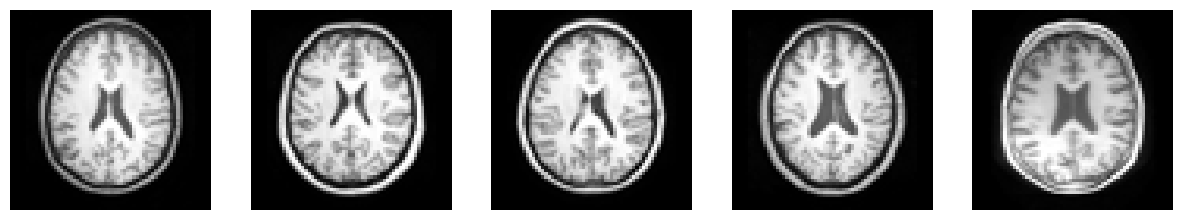

In [13]:
train_data_module = TrainDataModule(
    data_dir=config['train_data_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

## Prepare model

In [14]:
# Init model
model = AutoencoderModel(config)

max_epochs = config['num_epochs']
trainer = pl.Trainer(max_epochs=max_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Run training

In [16]:
# Train the model
trainer.fit(model, datamodule=train_data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 387 K 
1 | decoder | Sequential | 387 K 
---------------------------------------
775 K     Trainable params
0         Non-trainable params
775 K     Total params
3.102     Total estimated model params size (MB)


{'seed': 42, 'train_data_dir': './data/IXI', 'split_dir': './data/splits', 'target_size': [64, 64], 'batch_size': 32, 'lr': 0.001, 'num_epochs': 100}


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluation

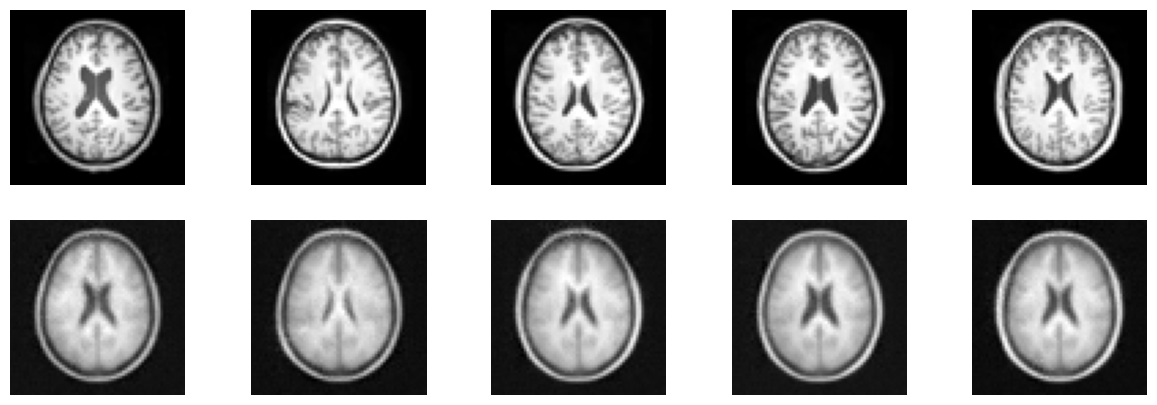

In [17]:
batch = next(iter(train_data_module.train_dataloader()))

with torch.inference_mode():
    results = model.detect_anomaly(batch)
    reconstructions = results['reconstruction']

# Plot images and reconstructions
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[i].squeeze(), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(reconstructions[i].squeeze(), cmap='gray')
    ax[1][i].axis('off')

In [20]:
from data_loader import get_all_test_dataloaders

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

In [21]:
test_dataloaders

{'absent_septum': <torch.utils.data.dataloader.DataLoader at 0x7f45608d28f0>,
 'artefacts': <torch.utils.data.dataloader.DataLoader at 0x7f45608d39d0>,
 'craniatomy': <torch.utils.data.dataloader.DataLoader at 0x7f45608d2ef0>,
 'dural': <torch.utils.data.dataloader.DataLoader at 0x7f45608d1900>,
 'ea_mass': <torch.utils.data.dataloader.DataLoader at 0x7f45608d3400>,
 'edema': <torch.utils.data.dataloader.DataLoader at 0x7f455a50f9d0>,
 'encephalomalacia': <torch.utils.data.dataloader.DataLoader at 0x7f455a50ecb0>,
 'enlarged_ventricles': <torch.utils.data.dataloader.DataLoader at 0x7f455a50e530>,
 'intraventricular': <torch.utils.data.dataloader.DataLoader at 0x7f455a50f070>,
 'lesions': <torch.utils.data.dataloader.DataLoader at 0x7f455a50f490>,
 'mass': <torch.utils.data.dataloader.DataLoader at 0x7f455a50fc10>,
 'posttreatment': <torch.utils.data.dataloader.DataLoader at 0x7f455a50f0a0>,
 'resection': <torch.utils.data.dataloader.DataLoader at 0x7f455a50e440>,
 'sinus': <torch.utils

## Visualize pathology and labels

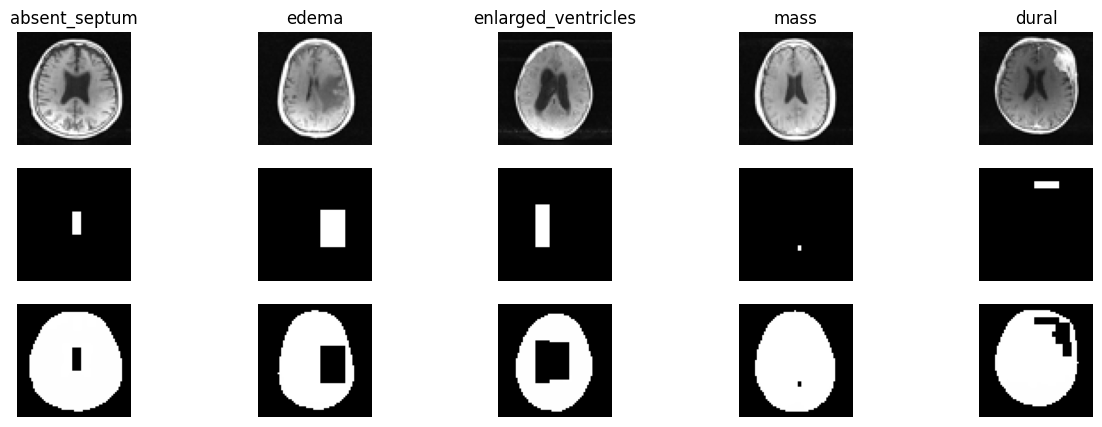

In [35]:
diseases = ['absent_septum', 'edema', 'enlarged_ventricles', 'mass', 'dural']
fig, ax = plt.subplots(3, len(diseases), figsize=(15, 5))
for i in range(len(diseases)):
  batch = next(iter(test_dataloaders[diseases[i]]))
  inputs, pos_labels, neg_masks = batch
  ax[0][i].imshow(inputs[i].squeeze(), cmap='gray')
  ax[0][i].axis('off')
  ax[1][i].imshow(pos_labels[i].squeeze(), cmap='gray')
  ax[1][i].axis('off')
  ax[2][i].imshow(neg_masks[i].squeeze(), cmap='gray')
  ax[2][i].axis('off')
  ax[0][i].set_title(diseases[i])

In [36]:
from evaluate import Evaluator 

evaluator = Evaluator(model, model.device, test_data_loader['mass'])

fig_metrics, metrics = evaluator.evaluate()

ModuleNotFoundError: ignored